## Imports: standard libraries, data processing & visualization


In [19]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from pypfopt import expected_returns, risk_models, EfficientFrontier, plotting
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# %matplotlib inline

## Data Acquisition & Returns Extraction

In [316]:
def download_data(ticker, start_date, end_date):
    try:
        df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
        df.dropna(inplace=True)
        return df
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")
        return pd.DataFrame()

def extract_price(df, freq=252):
    close = df["Adj Close"].dropna()
    returns = close.pct_change().dropna()
    returns_annual = expected_returns.mean_historical_return(close, frequency=freq) #frequency corresponds to number of working days in a year
    return close, returns, returns_annual

portfolio_keys = ["AAPL", "TSLA", "PFE", "JPM", "KO"] #Apple, Tesla, Pfizer, JP Morgan, Coca Cola
start_date = "2020-01-01"
end_date = "2025-01-01"
rf_rate = 0.05  #risk free rate

In [317]:
data = download_data(portfolio_keys, start_date, end_date)
price, daily_returns, annualized_returns = extract_price(data)

[*********************100%***********************]  5 of 5 completed


## Mean-Variance Optimization (MVO)

Apply the classic Markowitz MVO to construct the efficient frontier, compute the global minimum variance and tangency portfolios using empirical or shrinkage covariance estimation.

### Objective:

$$
\min_{w} \ w^T \Sigma w \quad \text{subject to} \quad \mathbf{1}^T w = 1
$$

where $w$ = portfolio weights, $\Sigma$ = covariance matrix.


In [442]:
# Define a risk model
def S(model: str, price :pd.DataFrame = price):
    if model == "covmat":
        sigma = risk_models.sample_cov(price)
    elif model == "shrink":
        sigma = risk_models.CovarianceShrinkage(price).ledoit_wolf()
    else:
        print("Error: Choose the correct risk model")
    return sigma

def compute_portfolio_metrics(exp_returns: pd.Series, cov_matrix: pd.DataFrame, risk_free_rate :float = rf_rate):
    # GMV Portfolio
    ef_gmv = EfficientFrontier(exp_returns, cov_matrix)
    w_gmv = ef_gmv.min_volatility()
    cleaned_w_gmv = ef_gmv.clean_weights()
    perf_gmv = ef_gmv.portfolio_performance(risk_free_rate=risk_free_rate)
    
    # Tangency Portfolio (Max Sharpe)
    ef_tan = EfficientFrontier(exp_returns, cov_matrix)
    w_tan = ef_tan.max_sharpe(risk_free_rate=risk_free_rate)
    cleaned_w_tan = ef_tan.clean_weights()
    perf_tan = ef_tan.portfolio_performance(risk_free_rate=risk_free_rate)
    
    results = {
        "GMV": {
            "weights": cleaned_w_gmv,
            "expected_return": perf_gmv[0],
            "annual_volatility": perf_gmv[1],
            "sharpe_ratio": perf_gmv[2]
        },
        "Tangency": {
            "weights": cleaned_w_tan,
            "expected_return": perf_tan[0],
            "annual_volatility": perf_tan[1],
            "sharpe_ratio": perf_tan[2]
        }
    }
    return results


In [436]:
equi_portfolio_returns = get_portfolio_returns(daily_returns, np.repeat(1 / price.shape[1], price.shape[1]))
equi_portfolio_value = get_cumulative_portfolio_value(equi_portfolio_returns, 10000)

<Axes: xlabel='Date'>

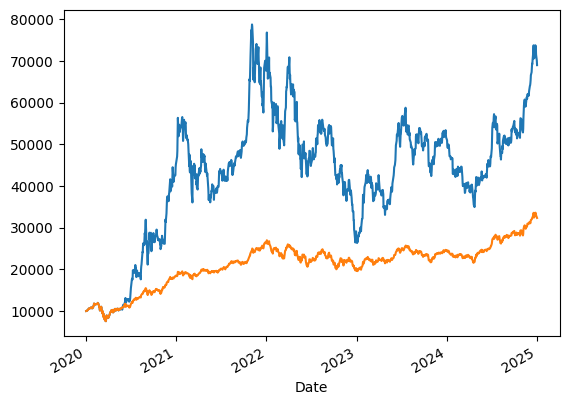

In [437]:
# a['weights'].plot()
a['portfolio_value'].plot()
equi_portfolio_value.plot()

## Portfolio Constraints and Customization

Enhance the optimizer by applying real-world constraints (no shorting, min/max weights) and re-calculating the optimal portfolios accordingly.


In [23]:
#add constraints to the portfolio
print(exp_returns_gmv, annual_volatility_gmv, sharpe_gmv)
ef_gmv = EfficientFrontier(annualized_returns, S("shrink"))
ef_gmv.add_constraint(lambda w: w >= 0) #no short selling, hence the weights must be non-negative
ef_gmv.add_constraint(lambda w: sum(w) ==1) #the weights are already normalized but still adding it as a constraint
ef_gmv.add_constraint(lambda w: w >= 0.05) #add a minimum weight for a single asset
ef_gmv.add_constraint(lambda w: w <= 0.4) #add a maximum weight for a single asset
weights_raw_gmv = ef_gmv.min_volatility()
weights_gmv = ef_gmv.clean_weights()
exp_returns_gmv, annual_volatility_gmv, sharpe_gmv = ef_gmv.portfolio_performance(verbose=False, risk_free_rate=rf_rate)
print("The new values after applying the constraints:")
print(exp_returns_gmv, annual_volatility_gmv, sharpe_gmv)

NameError: name 'exp_returns_gmv' is not defined

## Statistical Factor Model: PCA-Based Portfolio Optimization

Construct a factor-risk model using principal components analysis (PCA) on asset returns. Optimize the tangency portfolio using factor-driven risk rather than the full covariance matrix.

### Mathematical Representation

The PCA factor model:

$$
R = \beta F + \epsilon
$$
where $R$ = asset returns, $\beta$ = loadings matrix, $F$ = factor (PCA) returns, $\epsilon$ = idiosyncratic (specific) risk. In the matrix notation, the equation takes the following form:

$$
\Sigma = \beta \ \Omega \ \beta^{T} + D
$$


In [319]:
# Statistical Factor modelling
# returns = beta * statistical_factors + residuals
# x = daily_returns
num_factors = 3
def preprocess_data(x,n_comp):    
    # Scale features
    # scaler = StandardScaler()
    # x_scaled = scaler.fit_transform(x)
    x_scaled = x - x.mean()
    pca = PCA(n_components=n_comp)
    x_scaled_pca = pca.fit_transform(x)  #statistical factors 
    explained_var_pca = pca.explained_variance_ratio_
    return x_scaled, x_scaled_pca, explained_var_pca

x_scaled, x_pca, pca_explained_var = preprocess_data(daily_returns, num_factors)
#apply regression on the pca components
regression_model = LinearRegression(fit_intercept=True)
beta = np.zeros((x_scaled.shape[1], num_factors)) #the coefficient matrix of the statistical factors
residuals = np.zeros_like(x_scaled)

for i, col in enumerate(x_scaled.columns):
    y = x_scaled[col].values.reshape(-1,1)
    regression_model.fit(x_pca, y)
    beta[i, :] = regression_model.coef_.ravel()          # betas for asset i
    residuals[:, i] = (y.ravel() - regression_model.predict(x_pca).ravel())

#Convert into dataframes
# beta = pd.DataFrame(beta, columns=[f"F{i+1}" for i in range(num_factors)], index=daily_returns) 

In [320]:
omega = np.cov(x_pca, rowvar=False)
residuals_covmat = residuals.var(axis=0, ddof=1) 
sigma_factor = (beta @ omega @ beta.T + residuals_covmat) * 252 #multiply with the annualization factor 252

In [26]:
# For MVO (empirical or shrinkage covariance)
mvo_results = compute_portfolio_metrics(annualized_returns, S("shrink"))

# For factor model (PCA-based covariance)
factor_results = compute_portfolio_metrics(annualized_returns, sigma_factor)

# Access results
# print("GMV weights:", mvo_results["GMV"]["weights"])
# print("Tangency Sharpe:", factor_results["Tangency"]["sharpe_ratio"])

In [321]:
# sigma
# Tangency portfolio based on factor model
ef_shrp_factor = EfficientFrontier(annualized_returns, sigma_factor)
weights_raw_shrp_factor = ef_shrp_factor.max_sharpe()
weights_shrp_factor = ef_shrp_factor.clean_weights()
exp_returns_shrp_factor, annual_volatility_shrp_factor, sharpe_shrp_factor = ef_shrp_factor.portfolio_performance(verbose=False, risk_free_rate=rf_rate)
print(exp_returns_shrp_factor, annual_volatility_shrp_factor, sharpe_shrp_factor)

0.454048677556957 0.4130531117047996 1.0992501077717485


/home/devanshu/jupyter_env/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


## Discrete allocation of Equities

In [222]:

capital_invested = 10000
latest_prices = get_latest_prices(price)
discrete_shares = DiscreteAllocation(mvo_results["Tangency"]["weights"], latest_prices, total_portfolio_value=capital_invested)
allocation, remaining = discrete_shares.lp_portfolio()
print("Discrete share allocated for", capital_invested, "USD capital (MVO):", allocation, "Leftover:", remaining)

Discrete share allocated for 10000 USD capital (MVO): {'AAPL': 17, 'JPM': 22, 'KO': 3, 'TSLA': 1} Leftover: 11.188142065089778


## Tangency Portfolio Comparison and Visualization

Plot and compare the tangency portfolios constructed via both MVO and factor model-based approaches

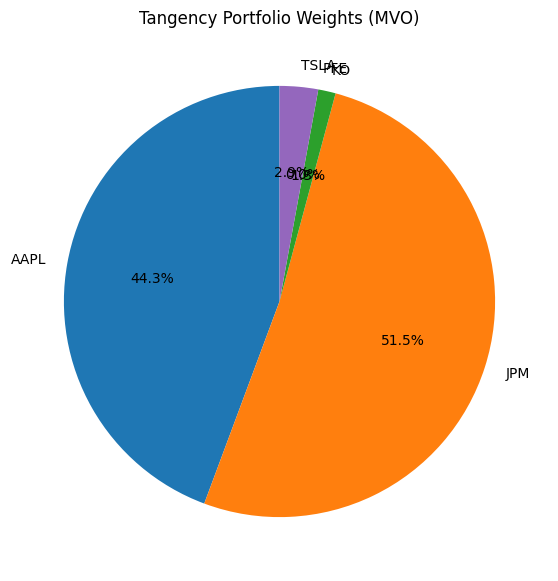

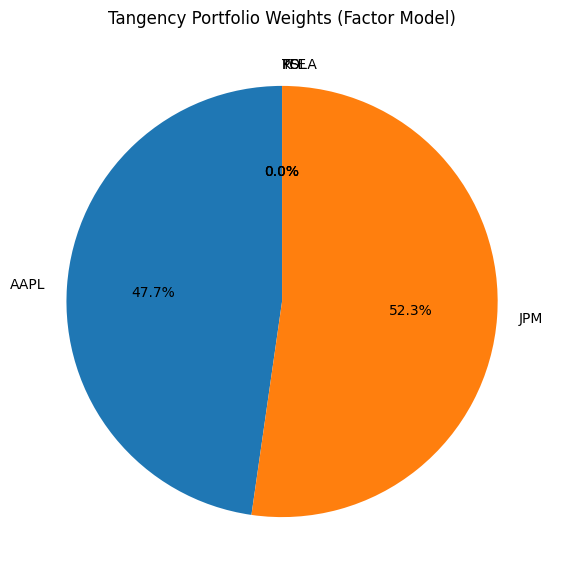

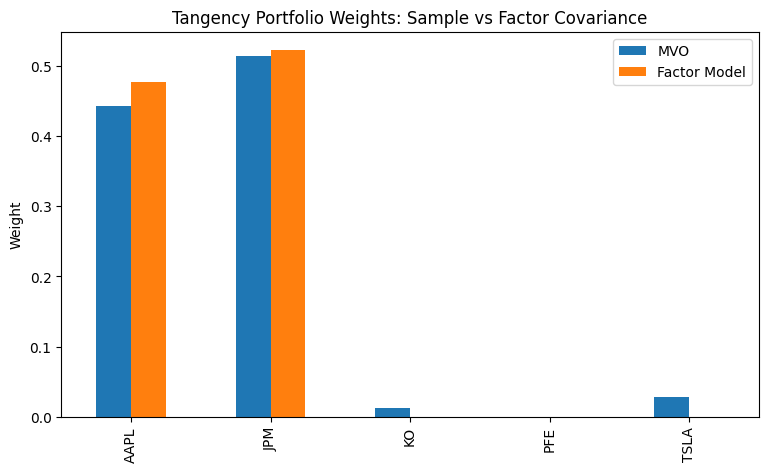

Weights comparison:
           MVO  Factor Model
AAPL  0.44326       0.47732
JPM   0.51484       0.52268
KO    0.01308       0.00000
PFE   0.00000       0.00000
TSLA  0.02882       0.00000


In [29]:
#plot the weights of the optimal portfolio
#MVO model
#plot the weights of the optimal portfolio
labels_mvo = list(mvo_results["Tangency"]["weights"].keys())
sizes_mvo = list(mvo_results["Tangency"]["weights"].values())

plt.figure(figsize=(7,7))
plt.pie(sizes_mvo, labels=labels_mvo, autopct="%1.1f%%", startangle=90)
plt.title("Tangency Portfolio Weights (MVO)")
plt.show()


#Factor model
labels_factor = list(factor_results["Tangency"]["weights"].keys())
sizes_factor = list(factor_results["Tangency"]["weights"].values())

plt.figure(figsize=(7,7))
plt.pie(sizes_factor, labels=labels_factor, autopct="%1.1f%%", startangle=90)
plt.title("Tangency Portfolio Weights (Factor Model)")
plt.show()

compare = pd.DataFrame({"MVO": mvo_results["Tangency"]["weights"], "Factor Model": factor_results["Tangency"]["weights"]}).fillna(0)

compare.plot.bar(figsize=(9,5))
plt.title("Tangency Portfolio Weights: Sample vs Factor Covariance")
plt.ylabel("Weight")
plt.show()

print("Weights comparison:\n", compare)

In [30]:
#Visualizations

##Capital Market Line (CML)
#y = Mx + C
C = rf_rate
M = (exp_returns_shrp - rf_rate)/annual_volatility_shrp
x_cml = np.linspace(0,0.5,500)
y_cml = M*x_cml + C

##Plot the efficient frontier curve with the 
fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(EfficientFrontier(annualized_returns, S("shrink")), ax=ax, show_assets=True)  # shows frontier + assets
# mark GMV and tangency
ax.scatter(annual_volatility_gmv, exp_returns_gmv, marker="D", s=100, label="GMV", color="orange")
ax.scatter(annual_volatility_shrp, exp_returns_shrp, marker="X", s=100, label="Tangency", color="red")
ax.plot(x_cml,y_cml, label="Capital Market Line")
ax.legend()
ax.set_title("Efficient Frontier (12-month history)")
plt.show()


NameError: name 'exp_returns_shrp' is not defined

# Miscellaneous

In [ ]:
# def plot_security_market_line():
#     R_f = 0.03  # 3% risk-free rate
#     E_R_m = 0.10  # 10% expected market return
#     market_risk_premium = E_R_m - R_f
    
#     # Generate beta values
#     betas = np.linspace(-0.5, 2.0, 100)
#     expected_returns = R_f + betas * market_risk_premium
    
#     plt.figure(figsize=(12, 8))
#     plt.plot(betas, expected_returns, 'b-', linewidth=3, label='Security Market Line (SML)')
    
#     # Mark key points
#     plt.plot(0, R_f, 'ro', markersize=10, label=f'Risk-Free Asset (β=0, Rf={R_f:.1%})')
#     plt.plot(1, E_R_m, 'go', markersize=10, label=f'Market Portfolio (β=1, E(Rm)={E_R_m:.1%})')
    
#     # Highlight different beta regions
#     plt.axvspan(-0.5, 0, alpha=0.1, color='green', label='Defensive Stocks (β < 0)')
#     plt.axvspan(0, 1, alpha=0.1, color='blue', label='Low Beta Stocks (0 < β < 1)')
#     plt.axvspan(1, 2, alpha=0.1, color='red', label='Aggressive Stocks (β > 1)')
    
#     plt.xlabel('Beta (β) - Systematic Risk', fontsize=12)
#     plt.ylabel('Expected Return E(Ri)', fontsize=12)
#     plt.title('Security Market Line (CAPM)', fontsize=14)
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.show()

# plot_security_market_line()

# Simulate and visualize the sub-optimal versions of a given portfolio

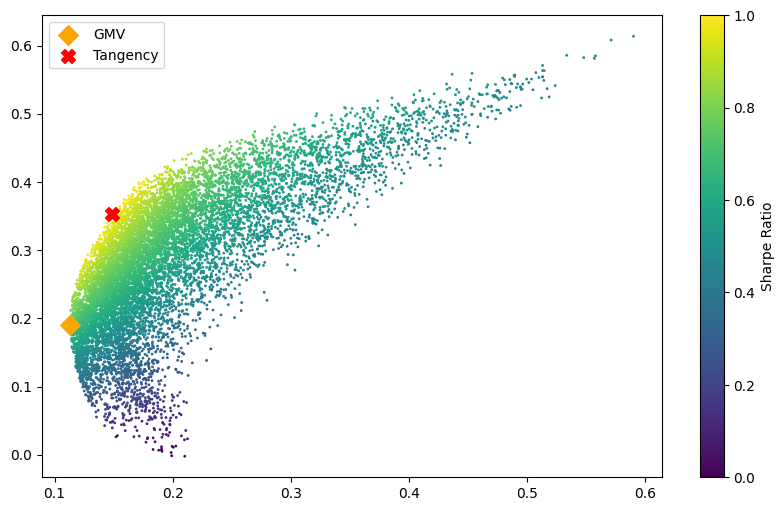

In [65]:

# sub_length = 100
# expected_returns_sub, risk_sub, sharpe_ratio_sub = np.zeros(sub_length), np.linspace(0.15, 0.6, sub_length), np.zeros(sub_length)

# for i in range(len(risk_sub)):
#     ef_temp = EfficientFrontier(annualized_returns, S("shrink"))
#     ef_temp.efficient_risk(risk_sub[i])
#     expected_returns_sub[i], risk_sub[i], sharpe_ratio_sub[i] = ef_temp.portfolio_performance(verbose=False)
    
    
# plt.figure(figsize=(8,6))
# plt.plot(risk_sub, expected_returns_sub, "b-", label="Efficient Frontier")
# plt.scatter(risk_sub, expected_returns_sub, c=sharpe_ratio_sub, cmap="viridis", marker="x")
# plt.colorbar(label="Sharpe Ratio")
# plt.xlabel("Volatility")
# plt.ylabel("Expected Return")
# plt.legend()
# plt.show()

n_random_portfolios = 10000
ef = EfficientFrontier(annualized_returns, S("shrink"))
n_weights = np.random.dirichlet(np.ones(ef.n_assets), n_random_portfolios)
n_expected_returns = n_weights.dot(ef.expected_returns)
n_volatility = np.sqrt(np.diag(n_weights @ ef.cov_matrix @ n_weights.T))
n_sharpes = n_expected_returns / n_volatility

plt.figure(figsize = (10,6))
plt.scatter(n_volatility, n_expected_returns, c=n_sharpes, cmap="viridis", s=1)
plt.scatter(annual_volatility_gmv, exp_returns_gmv, marker="D", s=100, label="GMV", color="orange")
plt.scatter(annual_volatility_shrp, exp_returns_shrp, marker="X", s=100, label="Tangency", color="red")

plt.colorbar(label="Sharpe Ratio")
plt.legend()

## ROUGH

In [ ]:

# #Define a risk model
# def S(model):
#     if model == "covmat":
#         sigma = risk_models.sample_cov(price)
#     elif model == "shrink":
#         sigma = risk_models.CovarianceShrinkage(price).ledoit_wolf()
#     else:
#         print("Error: Choose the correct risk model")
#     return sigma

# # Global Minimum Variance portfolio
# ef_gmv = EfficientFrontier(annualized_returns, S("shrink"))
# weights_raw_gmv = ef_gmv.min_volatility()
# weights_gmv = ef_gmv.clean_weights()
# exp_returns_gmv, annual_volatility_gmv, sharpe_gmv = ef_gmv.portfolio_performance(risk_free_rate=rf_rate)
# # print(exp_returns_gmv, annual_volatility_gmv, sharpe_gmv)
# # Tangency portfolio
# ef_shrp = EfficientFrontier(annualized_returns, S("shrink"))
# weights_raw_shrp = ef_shrp.max_sharpe()
# weights_shrp = ef_shrp.clean_weights()
# exp_returns_shrp, annual_volatility_shrp, sharpe_shrp = ef_shrp.portfolio_performance(risk_free_rate=rf_rate)
# print(exp_returns_shrp, annual_volatility_shrp, sharpe_shrp)

### Value at Risk (VaR)

VaR is a popular risk metric that identifies the probability that the portfolio could incur x% of loss within a specific time horizon (Example, 1 week). We create a function for evaluating VaR associated with our portfolio using Monte-Carlo simulation. The function

- Accepts daily returns, portfolio weights, time horizon, number of simulations, confidence level, and total capital invested in the portfolio
- Computes average daily returns and covariance matrix, and flattens the data into arrays
- Cholesky decomposition stores the correlation between assets in the portfolio
- Simulates a Mone-Carlo chain by sampling from a multivariate Gaussian distribution
- Multiplies with the Cholesky factor to account for the asset correlation in the stochastic price evolution
- Stores the cumulative returns for the time horizon corresponding to each stochastic realization
- The distribution of the simulated loss is used to compute VaR

In [205]:
def get_value_at_risk(returns: pd.Series, portfolio_weights: np.ndarray, days_horizon: int = 7, n_simulations: int = 10000, CL: float = 0.95, portfolio_value: float = 1000.0):
    # returns : multi asset returns not for single asset
    
    # time period for which future is simulated  : days_horizon
    mean_returns = returns.mean().values.reshape(-1, 1)
    covmat_returns = returns.cov().values
    weights = np.array(portfolio_weights)
    weights = weights.reshape(-1, 1)

    L = np.linalg.cholesky(covmat_returns) # Cholesky decomposition creates correlated random variables based on the covmat
    
    stochastic_returns = np.zeros(n_simulations)
    
    for i in range(n_simulations):
        cumulative_returns = 0.0
        for _ in range(days_horizon):
            rand_vec = np.random.normal(size=(len(mean_returns), 1))
            corr_returns = mean_returns + L @ rand_vec
            daily_returns = float(weights.T @ corr_returns)  # convert to a scalar portfolio return for that day
            cumulative_returns = cumulative_returns + daily_returns
        stochastic_returns[i] = cumulative_returns
    
    confidence_interval = CL * 100
    stochastic_losses = - portfolio_value * stochastic_returns
    
    VaR = np.percentile (stochastic_losses, confidence_interval)
    CVaR = stochastic_losses[stochastic_losses<=VaR].mean()    # conditional VaR which estimates the mean losses beyond VaR
    
    return {'VaR': VaR,
            'CVaR': CVaR,
            'distribution':stochastic_losses
           }


def compute_portfolio_var(returns: pd.DataFrame, weights: dict, **var_kwargs) -> dict:
    results = {}
    for name, w_dict in weights.items():
        w_array = np.array(list(w_dict.values()))
        results[name] = get_value_at_risk(returns, w_array, **var_kwargs)
    return results


def plot_var_distributions(var_results: dict):
    plt.figure(figsize=(10, 6))

    for name, res in var_results.items():
        losses = res["distribution"]
        var_value = res["VaR"]
        cvar_value = res['CVaR']
        plt.hist(
            losses,
            bins=30,
            alpha=0.5,
            label=name,
            log=True
        )
        plt.axvline(x=var_value, linestyle="--", label=f"{name} VaR")
        plt.axvline(x=cvar_value, linestyle="-", label=f"{name} CVaR")        

    plt.xlabel("Loss")
    plt.ylabel("Frequency")
    plt.title("Simulated Loss Distributions, VaR and CVaR")
    plt.legend()
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_10675/3478972033.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  daily_returns = float(weights.T @ corr_returns)  # convert to a scalar portfolio return for that day


Tangency mean simulated loss: -102.49
Tangency VaR: -560.89
Tangency CVaR: -672.97
GMV mean simulated loss: -50.04
GMV VaR: -335.07
GMV CVaR: -410.89


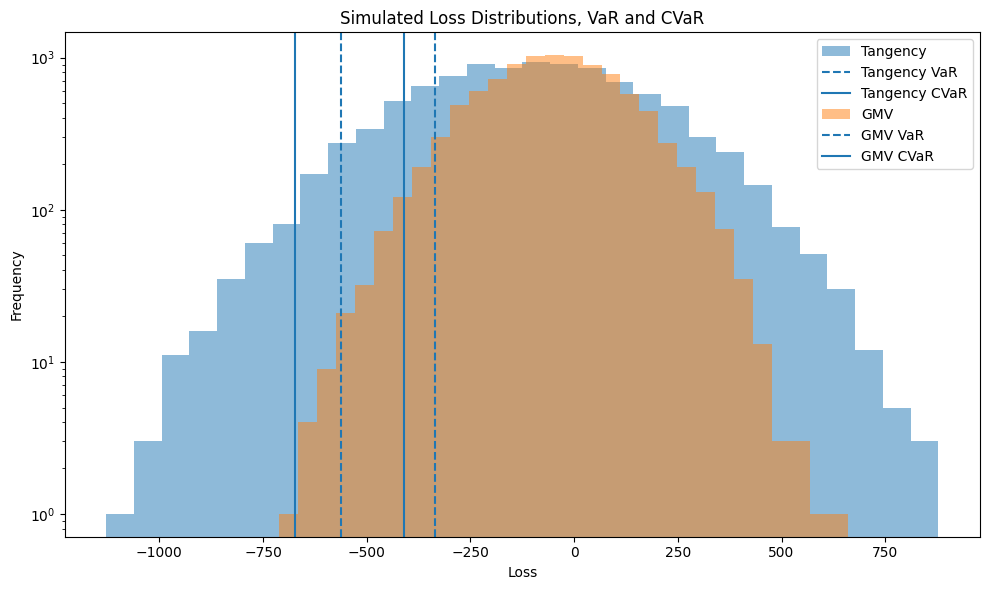

In [223]:
portfolio_weights = {
    "Tangency": mvo_results["Tangency"]["weights"],
    "GMV": mvo_results["GMV"]["weights"],
}

var_results = compute_portfolio_var(
    daily_returns,
    portfolio_weights,
    days_horizon=7,
    n_simulations=10000,
    CL=0.05,
    portfolio_value=10000.0,
)

for name, res in var_results.items():
    print(f"{name} mean simulated loss: {res['distribution'].mean():.2f}")
    print(f"{name} VaR: {res['VaR']:.2f}")
    print(f"{name} CVaR: {res['CVaR']:.2f}")

plot_var_distributions(var_results)


## Calendar-Based Portfolio Rebalancing

In practice, portfolio optimization is not a one-shot exercise. Market dynamics change over time, and the optimal asset allocation must be updated periodically using newly available information. This process is known as **rebalancing**.

In calendar-based rebalancing, the portfolio weights are recomputed at fixed time intervals (for example monthly or quarterly). At each rebalancing date, expected returns and risk are re-estimated using historical data available up to that date, and a new optimal portfolio is constructed. Between rebalancing dates, the portfolio weights are held constant, while the portfolio value evolves according to asset returns.

This approach allows us to:
- Adapt to changing market conditions
- Control risk over time
- Evaluate whether dynamic allocation improves performance compared to static portfolios

Below, we implement a calendar rebalancing engine using Mean-Variance Optimization and analyze its behavior through several visual diagnostics.


In [445]:
def get_cumulative_portfolio_value(portfolio_returns: pd.Series, initial_value=10000):
    
    return initial_value * (1 + portfolio_returns).cumprod()
    
def get_portfolio_returns(returns: pd.DataFrame, weights: pd.DataFrame):
    
    return (returns * weights).sum(axis=1)

def rebalance_engine(
    price: pd.DataFrame,
    rebalance_period: int,
    initial_value: float = 10000,
    risk_free_rate: float = 0.05
):
    returns = price.pct_change().dropna()
    dates = returns.index

    weights = pd.DataFrame(
        index=dates,
        columns=price.columns,
        dtype=float
    )

    # Initial equal-weight portfolio
    current_weights = np.repeat(1 / price.shape[1], price.shape[1])
    weights.iloc[0] = current_weights

    rebalance_dates = dates[::rebalance_period]
    
    # Initialize mvo_results with initial weights
    mvo_results = None

    for t in dates[1:]:
        if t in rebalance_dates:
            price_slice = price.loc[:t]

            mu = expected_returns.mean_historical_return(
                price_slice,
                frequency=252
            )

            Sigma = S('shrink', price_slice)

            mvo_results = compute_portfolio_metrics(mu, Sigma)
            
        # Check if mvo_results exists before accessing it
        if mvo_results is not None:
            weights.loc[t] = list(mvo_results["Tangency"]["weights"].values())
        else:
            # Use initial weights if no rebalancing has occurred yet
            weights.loc[t] = current_weights

    portfolio_returns = get_portfolio_returns(returns, weights)
    portfolio_value = get_cumulative_portfolio_value(
        portfolio_returns,
        initial_value
    )

    return {
        "weights": weights,
        "portfolio_returns": portfolio_returns,
        "portfolio_value": portfolio_value
    }

rebalanced_results = rebalance_engine(rebalance_period=60, price=price)

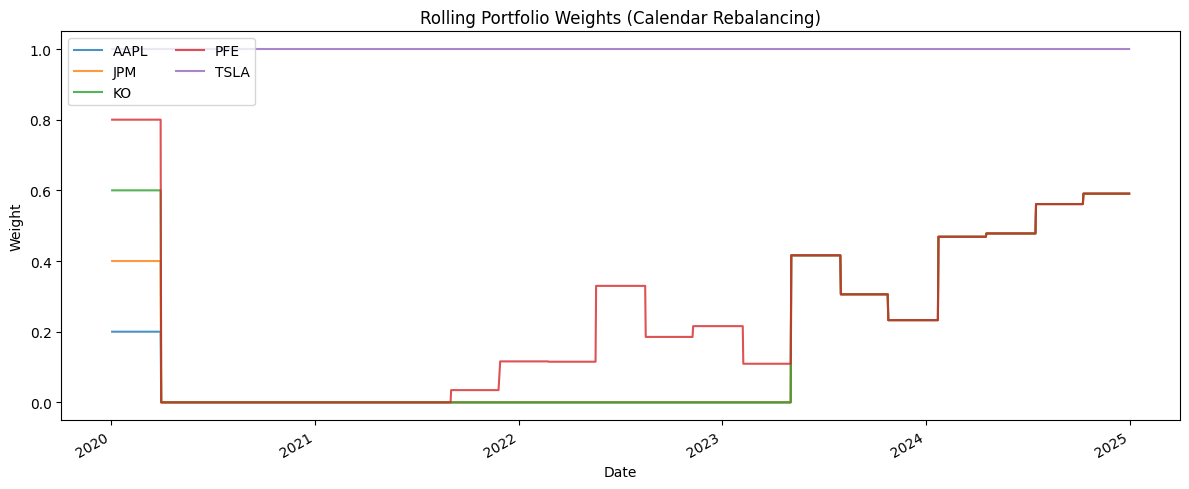

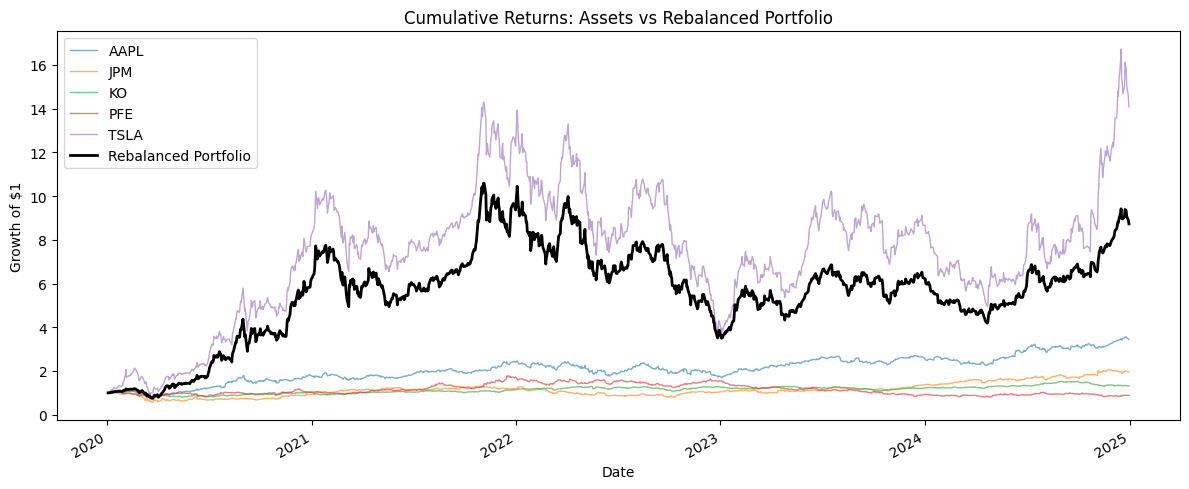

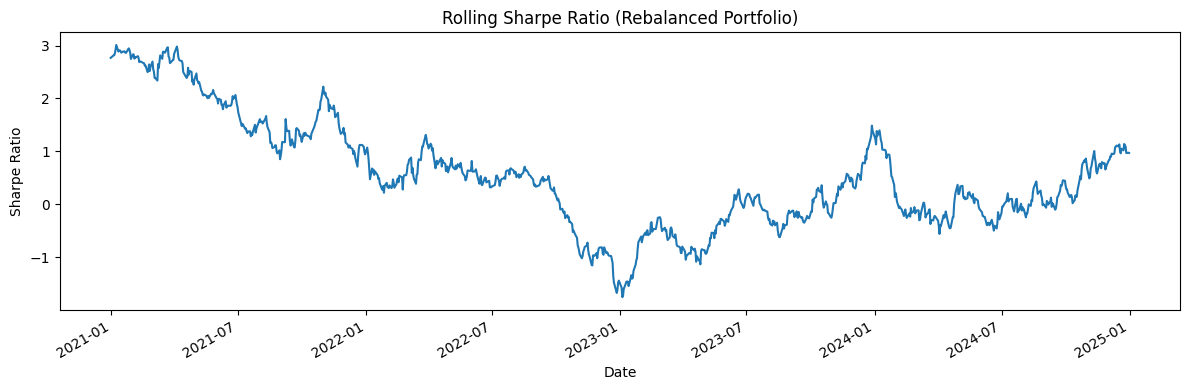

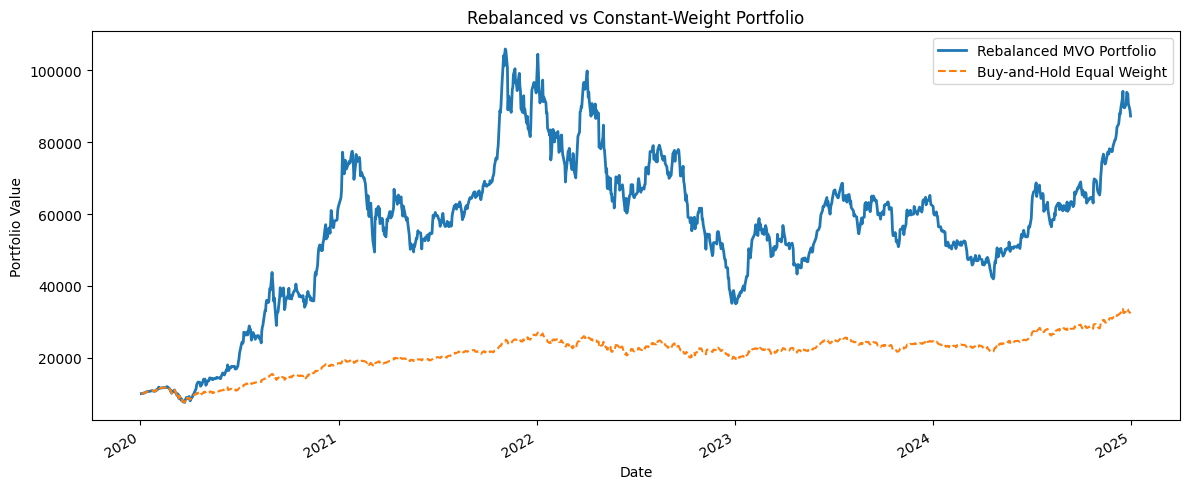

In [472]:
weights = rebalanced_results["weights"]
portfolio_value = rebalanced_results["portfolio_value"]
portfolio_returns = rebalanced_results["portfolio_returns"]
cum_asset_rets = get_cumulative_portfolio_value(price.pct_change(), initial_value=10000) # (1 + price.pct_change()).cumprod()

# plot rolling portfolio weights
weights.plot(
    # kind="area",
    stacked=True,
    figsize=(12, 5),
    alpha=0.8
)

plt.title("Rolling Portfolio Weights (Calendar Rebalancing)")
plt.ylabel("Weight")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=2)
plt.tight_layout()
plt.show()

# plot asset returns vs portfolio returns (cumulative)


fig, ax = plt.subplots(figsize=(12, 5))

cum_asset_rets.div(10000).plot(ax=ax, alpha=0.6, linewidth=1)
portfolio_value.div(10000).plot(
    ax=ax,
    color="black",
    linewidth=2,
    label="Rebalanced Portfolio"
)

ax.set_title("Cumulative Returns: Assets vs Rebalanced Portfolio")
ax.set_ylabel("Growth of $1")
ax.legend()
plt.tight_layout()
plt.show()

# plot rolling sharpe ratio
window = 252  # 1 year rolling window
rf_daily = rf_rate / 252


rolling_sharpe = (
    (portfolio_returns.rolling(window).mean() - rf_daily) /
    portfolio_returns.rolling(window).std()
) * np.sqrt(252)

rolling_sharpe.plot(figsize=(12, 4))
plt.title("Rolling Sharpe Ratio (Rebalanced Portfolio)")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


# Rebalanced portfolio vs constant weight portfolio
equal_weights = np.repeat(1 / price.shape[1], price.shape[1])
equal_weight_returns = price.pct_change().dot(equal_weights)
equal_weight_value = (1 + equal_weight_returns).cumprod() * 10_000

fig, ax = plt.subplots(figsize=(12, 5))

portfolio_value.plot(
    ax=ax,
    linewidth=2,
    label="Rebalanced MVO Portfolio"
)

equal_weight_value.plot(
    ax=ax,
    linestyle="--",
    label="Buy-and-Hold Equal Weight"
)

ax.set_title("Rebalanced vs Constant-Weight Portfolio")
ax.set_ylabel("Portfolio Value")
ax.legend()
plt.tight_layout()
plt.show()


## To Do Next

- Implement FAMA FRENCH 3-factor model & include macroeconomic factors
- Portfolio rebalancing on a rolling basis (Done)
- Compare the weights with GP-based optimization
- Backtesting optimization
- Log optimal portfolio